In [13]:
# io
import os
import re

# sentence tokenization
import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt')

# huggingface
from transformers import pipeline

# plots
import numpy as np
import matplotlib.pyplot as plt


[nltk_data] Downloading package punkt to /home/hp/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


---
# Summarize text for each model

In [4]:
INPUT_DIR = 'part3-text'
OUTPUT_DIR = 'part3-text'

In [5]:
def get_pred(model):
    print("#"*100)
    print(model)
    pipe = pipeline("summarization", model=model, device=0)
    print("model loaded")
    # get number of samples
    sample_fn = os.listdir(INPUT_DIR)
    sample_fn = list(filter(lambda x: 'inp' in x.lower(), sample_fn))
    n_samples = len(sample_fn)

    # get filenames
    inp_fn = [os.path.join(INPUT_DIR, f'inp{i}.txt') for i in range(1,n_samples+1)]
    print('input text filenames:', inp_fn)

    # load in texts
    def clean_context(filename):
        with open(filename, 'r', encoding="utf8") as f:
            text = f.read()
        text = re.sub("\n", r' ', text)
        text = re.sub(r"\s{2,}", r' ', text)
        text = re.sub(r"“|”", r'"', text)
        text = re.sub(r"‘|’", r"'", text)
        text = re.sub(r"_", r'', text, re.ASCII)
        text = re.sub(r"\s{2,}", r' ', text)
        text = text.strip()
        return text

    inp_text = [clean_context(fn) for fn in inp_fn]

    query_lens = [len(q) for q in inp_text]
    predictions = []
    for i, inp in enumerate(inp_text):
        print(f'Summarizing Input {i+1}')
        predictions.append(pipe(inp))
    print("Done")

    def clean_pred(preds, query_lens):
        out = []
        for p, n in zip(preds, query_lens):
            for x in p:
                if 'pegasus' in model.lower():
                    out.append(x['summary_text'].replace(" .<n>", ".\n"))
                else:
                    out.append('\n'.join(sent_tokenize(x['summary_text'])))
            print(out[-1])
        return out
    predictions = clean_pred(predictions, query_lens)

    # free up memory for next run
    del pipe

    #return predictions
    return predictions

models = ['facebook/bart-large-cnn', 't5-large',  'google/pegasus-xsum']
preds = {}
for m in models:
    preds[m] = get_pred(m)

####################################################################################################
facebook/bart-large-cnn


2022-12-04 14:34:36.660326: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 14:34:36.673720: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 14:34:36.673808: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 14:34:36.674288: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compi

model loaded
input text filenames: ['part3-text/inp1.txt', 'part3-text/inp2.txt', 'part3-text/inp3.txt', 'part3-text/inp4.txt']
Summarizing Input 1
Summarizing Input 2
Summarizing Input 3
Summarizing Input 4
Done
"The facts of the case are simple.
Sir Charles Baskerville was in the habit every night before going to bed of walking down the famous yew alley" "No signs of violence were to be discovered upon Sir Charles's person" "The coroner's jury returned a verdict in accordance with the medical evidence" " inquiries are being instituted with a view to informing him of his good fortune"
"He found a way out of his difficulties through the chance that Sir Charles, who had conceived a friendship for him, made him the minister of his charity in the case of Mrs. Laura Lyons" "By representing himself as a single man he acquired complete influence over her, and he gave her to understand that in the event of her obtaining a divorce from her husband he would marry her.
His plans were suddenly br

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at t5-large.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.
/home/hp/.conda/envs/huggingface/lib/python3.8/site-packages/transformers/models/t5/tokenization_t5_fast.py:156: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-large automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encodin

model loaded
input text filenames: ['part3-text/inp1.txt', 'part3-text/inp2.txt', 'part3-text/inp3.txt', 'part3-text/inp4.txt']
Summarizing Input 1


2022-12-04 14:36:02.633477: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x55f56866fa40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-12-04 14:36:02.633504: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2022-12-04 14:36:02.636552: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-12-04 14:36:02.650721: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-04 14:36:02.668063: I tensorflow/compiler/jit/xla_compilation_cache.cc:476] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Summarizing Input 2
Summarizing Input 3
Summarizing Input 4
Done
"sir Charles Baskerville was in the habit every night before going to bed" "the evidence of the Barrymores shows that this had been his custom," "the coroner's jury returned a verdict in accordance with the medical evidence" "it is obviously of the utmost importance that Sir Charles's heir should settle at the Hall"
"he found a way out of his difficulties through the chance that sir Charles made him minister of his charity in the case of unfortunate woman, Mrs. Laura Lyons" by representing himself as a single man he acquired complete influence over her .
he then put pressure upon Mrs. Lyons to write this letter, imploring the old man to give her an interview on the evening before his departure .
"the other words were all simple and might be found in any issue, but 'moor' would be less common" "have you read anything else in this message, Mr.
Holmes?"
he asks .
"the address, you observe, is printed in rough characters, but

All model checkpoint layers were used when initializing TFPegasusForConditionalGeneration.

Some layers of TFPegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['final_logits_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Token indices sequence length is longer than the specified maximum sequence length for this model (572 > 512). Running this sequence through the model will result in indexing errors


model loaded
input text filenames: ['part3-text/inp1.txt', 'part3-text/inp2.txt', 'part3-text/inp3.txt', 'part3-text/inp4.txt']
Summarizing Input 1
Summarizing Input 2
Summarizing Input 3
Summarizing Input 4
Done
The coroner's jury report for the inquest into the death of Sir Charles Baskerville, the master of Mayes Barrymore, who was found dead on the moor on the morning of the 4th of May, 1847.
The murder of a baronet by a hound in Gloucestershire in 1666 is the subject of a new novel by Thomas Hardy.
A letter to the editor of the Times from Sir Henry VIII.
The coroner's report on the inquest into the death of Sir Charles Barrymore.


---
# Get Scores for Predictions

In [9]:
# get number of samples
sample_fn = os.listdir(INPUT_DIR)
sample_fn = list(filter(lambda x: 'inp' in x.lower(), sample_fn))
n_samples = len(sample_fn)

# get filenames
ref_fn = [os.path.join(INPUT_DIR, f'ref{i}.txt') for i in range(1,n_samples+1)]
print('reference text filenames:', ref_fn)
def clean_context(filename):
    with open(filename, 'r', encoding="utf8") as f:
        text = f.read()
    text = re.sub("\n", r' ', text)
    text = re.sub(r"\s{2,}", r' ', text)
    text = re.sub(r"“|”", r'"', text)
    text = re.sub(r"‘|’", r"'", text)
    text = re.sub(r"_", r'', text, re.ASCII)
    text = re.sub(r"\s{2,}", r' ', text)
    text = text.strip()
    return text
ref_text = ["\n".join(sent_tokenize(clean_context(fn))) for fn in ref_fn]

reference text filenames: ['part3-text/ref1.txt', 'part3-text/ref2.txt', 'part3-text/ref3.txt', 'part3-text/ref4.txt']


In [8]:
import evaluate

rouge = evaluate.load('rouge')

def eval_rouge(predictions, references):
    global rouge
    results = rouge.compute(
        predictions=predictions,
        references=references
    )
    return results

In [10]:
scores = {}
for m in models:
    scores[m] =  eval_rouge(preds[m], ref_text)

In [11]:
scores

{'facebook/bart-large-cnn': {'rouge1': 0.3436942087836211,
  'rouge2': 0.08957020986038977,
  'rougeL': 0.20360193443286578,
  'rougeLsum': 0.2907314668791361},
 't5-large': {'rouge1': 0.30477971889501143,
  'rouge2': 0.08313524369280692,
  'rougeL': 0.172717101887657,
  'rougeLsum': 0.2431638779022941},
 'google/pegasus-xsum': {'rouge1': 0.19887806370386057,
  'rouge2': 0.03591026955315684,
  'rougeL': 0.1259067563274383,
  'rougeLsum': 0.18196738913010224}}

---
# Plots Scores

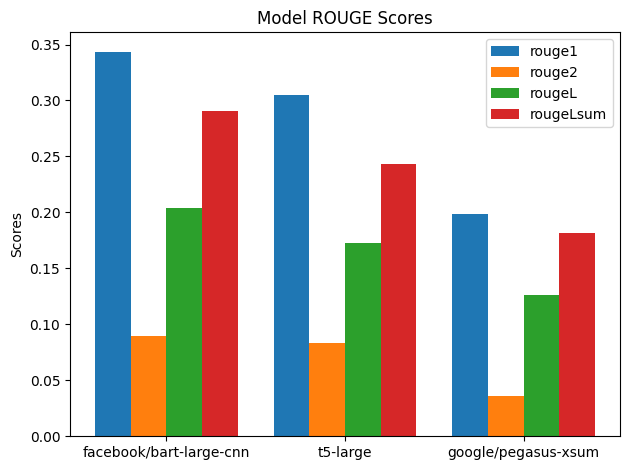

In [18]:
fig, ax = plt.subplots()

labels = list(scores.keys())
x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

# ax.set_ylabel('Scores')
plt.ylabel("Scores")
# ax.set_title(
plt.title('Model ROUGE Scores')
plt.xticks(x+width*2.5,labels)

rouge1 = [scores[k]['rouge1'] for k in labels]
rouge2 = [scores[k]['rouge2'] for k in labels]
rougeL = [scores[k]['rougeL'] for k in labels]
rougeLsum = [scores[k]['rougeLsum'] for k in labels]

plt.bar(x+width, rouge1, width=width, label='rouge1')
plt.bar(x+width*2, rouge2, width=width, label='rouge2')
plt.bar(x+width*3, rougeL, width=width, label='rougeL')
plt.bar(x+width*4, rougeLsum, width=width, label='rougeLsum')


plt.tight_layout()
plt.legend()

plt.savefig('plots/rouge-scores.png', dpi=500)
plt.show()